In [112]:
import os
import numpy as np
import dlib
import cv2
from scipy.misc import *
import matplotlib.pyplot as plt
from glob import glob
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
CLASS2LBL = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

def parse_lbl(fname):
    _class = fname.split('/')[-2]
    return CLASS2LBL[_class]

In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 10))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig('confusion_release.png')

## 1. Подготовим данные

In [48]:
DATA_PATH = '/home/_datasets_/emotiw2017/'
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'
IMG_TMPL = '*.jpg'
PREDICTOR_PATH = '/home/arassadin/distr/shape_predictor_68_face_landmarks.dat'
OUT_SIZE = (224, 224)

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [49]:
files_train = glob(os.path.join(DATA_PATH, TRAIN_DIR, '*', '*'))
files_val = glob(os.path.join(DATA_PATH, VAL_DIR, '*', '*'))
files_test = glob(os.path.join(DATA_PATH, TEST_DIR, '*'))

print len(files_train), len(files_val), len(files_test)

3630 2065 772


In [23]:
files_test[14]

'/home/_datasets_/emotiw2017/test/1997_Convocation.jpg'

In [28]:
def find_faces(img):
    try:
        rects = detector(img, 1)
    except:
        return None
    faces = []

    for rect in rects:
        y1 = rect.top()
        if y1 < 0:
            y1 = 0
        y2 = rect.bottom()
        if y2 > img.shape[0]:
            y2 = img.shape[0]
        x1 = rect.left()
        if x1 < 0:
            x1 = 0
        x2 = rect.right()
        if x2 > img.shape[1]:
            x2 = img.shape[1]
        faces.append(img[y1:y2, x1:x2])
    
    return faces

In [9]:
def get_dst(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt(np.square(y2 - y1) + np.square(x2 - x1))

In [10]:
def find_landmarks(face):
    bbox = dlib.rectangle(0, 0, face.shape[1] - 1, face.shape[0] - 1)
    shape = predictor(face, bbox)
    landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    leftmost = min([l[0] for l in landmarks])
    topmost = min([l[1] for l in landmarks])
    landmarks = [(l[0] - leftmost, l[1] - topmost) for l in landmarks]
    dsts = []
    for i in range(68):
        for j in range(i + 1, 68):
            dsts.append(get_dst(landmarks[i], landmarks[j]))
    dsts = np.asarray(dsts)
    dsts /= dsts.max()
    return dsts

In [ ]:
if not os.path.exists('./data'):
    os.makedirs('./data')

fault_counter = 0
def routine(files):
    global fault_counter
    data_faces, data_dsts = {}, {}
    for fname in log_progress(files):
        img = imread(fname, mode='RGB')
        faces = find_faces(img)
        if faces is None:
            print 'Something wrong with image {}!'.format(fname)
            continue
        if len(faces) == 0:
            fault_counter += 1
            continue

        dsts = [find_landmarks(f) for f in faces]
        faces = [imresize(f, OUT_SIZE) for f in faces]
        
        data_faces[fname] = faces
        data_dsts[fname] = dsts
    return data_faces, data_dsts

faces_train, dsts_train = routine(files_train)
np.save('data/faces_train', faces_train); np.save('data/dsts_train', dsts_train)
print len(files_train), len(faces_train), len(dsts_train)

faces_val, dsts_val = routine(files_val)
np.save('data/faces_val', faces_val); np.save('data/dsts_val', dsts_val)
print len(files_val), len(faces_val), len(dsts_val)

faces_test, dsts_test = routine(files_test[14:])
np.save('data/faces_test', faces_test); np.save('data/dsts_test', dsts_test)
print len(files_test), len(faces_test), len(dsts_test)

print 'No faces found on {} photos'.format(fault_counter)

Something wrong with image /home/_datasets_/emotiw2017/test/1997_Convocation.jpg!


In [56]:
y_train = {}
for fname in files_train:
    y_train[fname] = parse_lbl(fname)
    
y_val = {}
for fname in files_val:
    y_val[fname] = parse_lbl(fname)
    
print np.unique(y_train.values())
print np.unique(y_val.values())

np.save('data/y_train', y_train)
np.save('data/y_val', y_val)

[0 1 2]
[0 1 2]


## 2. Сбор нейросетевых скорингов

In [5]:
def normalize_vggface_1(arr):
    arr = arr[::-1, :, :].astype(np.float32)

    arr[0, :, :] -= 93.5940
    arr[1, :, :] -= 104.7624
    arr[2, :, :] -= 129.1863

    return arr

In [6]:
def normalize_vggface_2(arr):
    arr = arr[:, :, :].astype(np.float32)

    arr[0, :, :] -= 93.5940
    arr[1, :, :] -= 104.7624
    arr[2, :, :] -= 129.1863

    return arr

In [10]:
def routine1(data, model, norm_f):
    scores = {}
    for fname in log_progress(data.keys()):
#         _class = fname.split('/')[-2]
#         lbl = CLASS2LBL[_class]
#         scores_y.append(lbl)
        
        if len(data[fname]) < 1:
            continue
        faces = np.asarray([norm_f(np.moveaxis(face, 2, 0)) for face in data[fname]])
        preds = model.predict(faces)
        scores[fname] = np.median(preds, axis=0)
        # break
    return scores

def routine2(fname, model, m='default'):
    data = np.load(fname).item()
    for i, norm_f in enumerate([normalize_vggface_1, normalize_vggface_2], start=1):
        scores = routine1(data, model, norm_f)
        postfix = os.path.basename(fname).split('_')[-1]
        np.save('data/scores_{}_norm={}_model={}'.format(postfix, i, m), scores)

model = VGGFace(include_top=False, input_shape=(3, 224, 224), pooling='avg')
routine2('data/faces_train.npy', model, m='vgg-face-avgpool')
routine2('data/faces_val.npy', model, m='vgg-face-avgpool')
routine2('data/faces_test.npy', model, m='vgg-face-avgpool')

vgg_faces = VGGFace()
out = vgg_faces.get_layer('fc7').output
model = Model(vgg_faces.input, out)
routine2('data/faces_train.npy', model, m='vgg-face-fc7')
routine2('data/faces_val.npy', model, m='vgg-face-fc7')
routine2('data/faces_test.npy', model, m='vgg-face-fc7')

## 3. Обучение слабых классификаторов и сбор их скорингов

In [75]:
def parse_X_y_flat(d):
    X, y = [], []
    for fname in log_progress(d.keys()):
        print d[fname].shape
        return None
        for el in d[fname]:
            y.append(parse_lbl(fname))
            X.append(el)
    X = np.asarray(X)
    y = np.asarray(y, np.uint8)
    return X, y

In [90]:
def parse_X_y(d):
    X, y = [], []
    for fname in log_progress(d.keys()):
        X.append(d[fname])
        y.append(parse_lbl(fname))
    X = np.asarray(X)
    y = np.asarray(y, np.uint8)
    return X, y, d.keys()

In [46]:
def probs_deflate(probs_pred, d):
    probs_deflated = {}

    cur_position = 0
    for fname in log_progress(d.keys()):
        q = len(dsts_val[fname])
        score = np.sum(probs_pred[cur_position : cur_position + q], axis=0)
        probs_deflated[fname] = score
        cur_position += q
    #     break

    return probs_deflated

In [63]:
def get_scores(y_true, probs_pred):
    accuracy = 0.0
    for f in log_progress(probs_pred.keys()):
        if y_true[f] == np.argmax(probs_pred[f]):
            accuracy += 1
    return accuracy / len(probs_pred)

### train / val

Лендмарки:

In [22]:
dsts_X_train, dsts_y_train = parse_X_y_flat(np.load('data/dsts_train.npy').item())
dsts_val = np.load('data/dsts_val.npy').item()
dsts_X_val, dsts_y_val = parse_X_y_flat(dsts_val)

print dsts_X_train.shape, dsts_y_train.shape
print dsts_X_val.shape, dsts_y_val.shape

(12768, 2278) (12768,)
(7202, 2278) (7202,)


In [27]:
predictor_dsts = OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16)).fit(dsts_X_train, dsts_y_train)

In [30]:
tmp_probs = predictor_dsts.predict_proba(dsts_X_val)
print tmp_probs.shape

(7202, 3)


In [47]:
dsts_probs_pred = probs_deflate(tmp_probs, dsts_val)
print len(dsts_probs_pred)

1998


In [64]:
print get_scores(np.load('data/y_val.npy').item(), dsts_probs_pred)

0.642642642643


In [65]:
np.save('data/probs_dsts_val', dsts_probs)

Нейронки:

In [66]:
nn_scores_train_fnames = ['data/scores_train.npy_norm=1_model=vgg-face-avgpool.npy',
                          'data/scores_train.npy_norm=1_model=vgg-face-fc7.npy',
                          'data/scores_train.npy_norm=2_model=vgg-face-avgpool.npy',
                          'data/scores_train.npy_norm=2_model=vgg-face-fc7.npy']
nn_scores_val_fnames = ['data/scores_val.npy_norm=1_model=vgg-face-avgpool.npy',
                        'data/scores_val.npy_norm=1_model=vgg-face-fc7.npy',
                        'data/scores_val.npy_norm=2_model=vgg-face-avgpool.npy',
                        'data/scores_val.npy_norm=2_model=vgg-face-fc7.npy']

In [68]:
nn_scores_train = [np.load(x).item() for x in nn_scores_train_fnames]
nn_scores_val = [np.load(x).item() for x in nn_scores_val_fnames]

print len(nn_scores_train), len(nn_scores_val)

4 4


In [82]:
preds_decl = ['OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=1000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=1000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16))']

nn_predictors= []
for scores, decl in log_progress(zip(nn_scores_train, preds_decl)):
    tmp_X, tmp_y, _ = parse_X_y(scores)
    nn_predictors.append(eval(decl).fit(tmp_X, tmp_y))

In [94]:
nn_probs_pred = []

for scores, predictor in log_progress(zip(nn_scores_val, nn_predictors)):
    tmp_X, tmp_y, fnames = parse_X_y(scores)
    tmp_probs = predictor.predict_proba(tmp_X)
    nn_probs_pred.append(dict(zip(fnames, tmp_probs)))
    print np.mean(tmp_y == np.argmax(tmp_probs, axis=1))
#     break

0.697197197197


0.678178178178


0.695195195195


0.678678678679


In [96]:
np.save('data/probs_nn_val', nn_probs_pred)

### train + val / test

## 4. Сбор ансамбля

In [99]:
probs_dsts_fname = 'data/probs_dsts_val.npy'
weight_dsts = 0.66

probs_nn_fname = 'data/probs_nn_val.npy'
weights_nn = [0.7, 0.7, 0.7, 0.7]

In [98]:
probs_dsts = np.load(probs_dsts_fname).item()
probs_nn = np.load(probs_nn_fname)

In [103]:
ys_true = np.load('data/y_val.npy').item()
print len(ys_true)

2065


In [107]:
y_true = []
y_pred = []

for fname in log_progress(probs_dsts.keys()):
    preds = np.zeros((3,))
    preds += probs_dsts[fname] * weight_dsts
    for tmp_probs, w in zip(probs_nn, weights):
        preds += tmp_probs[fname] * w
    y_pred.append(np.argmax(preds))
    y_true.append(ys_true[fname])
#     break
    
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

In [108]:
print np.mean(y_true == y_pred)

0.724224224224


[[ 0.74  0.18  0.08]
 [ 0.3   0.63  0.07]
 [ 0.07  0.13  0.8 ]]


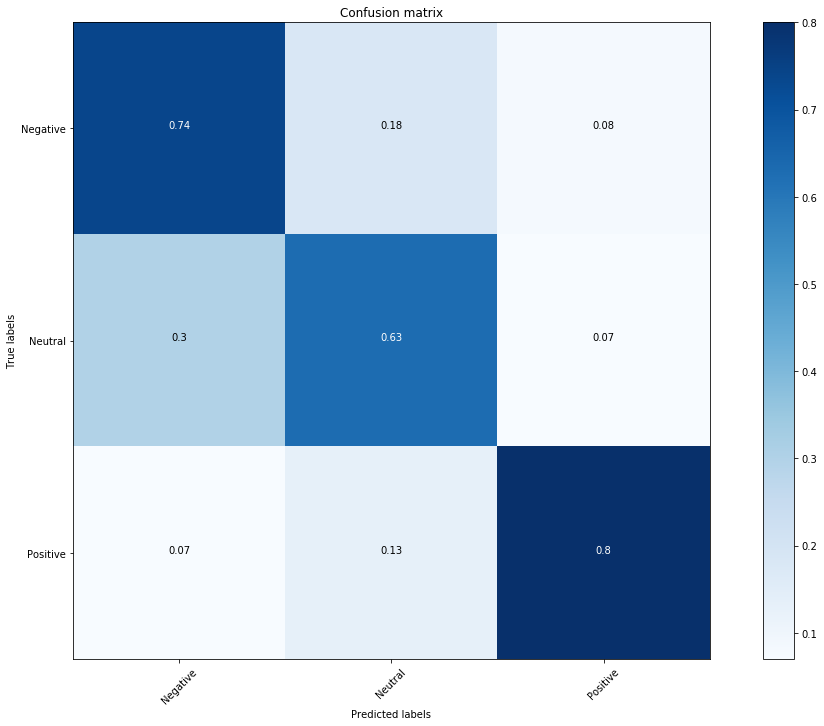

In [113]:
cmtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cmtx, ['Negative', 'Neutral', 'Positive'], normalize=True)